In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

from utils import *
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

model_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
behavior_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehVar-main/Rats"

In [3]:
# extract and concatenate train and test data
all_rat_data = {}

# get mat files
mat_files = glob.glob(os.path.join(model_dir, "*.mat"))

for file in mat_files:
    rat = os.path.basename(file).split('.')[0]
    mat_data = load_mat_file(file)
    folds = mat_data.get('BestFit_Folds', [])

    # extract training and testing data
    train_df = extract_train_trials(folds, rat=rat)
    test_df = extract_test_trials(folds, rat=rat)
    
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    all_rat_data[rat] = combined_df

In [24]:
# function to perform random splits and analysis with stratification
def analyze_random_splits(data_df, k=500, rat_id=None, seed=42):
    """
    Perform k random 50/50 splits of the data with stratification by block
    Only uses optout trials without violations
    """
    # set random seed for reproducibility
    np.random.seed(seed)
    
    # filter for only optout trials without violations
    filtered_df = data_df[(data_df['optout'] == 1) & (data_df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)
    
    # check if we have all blocks
    unique_blocks = filtered_df['block'].unique()
    if len(unique_blocks) < 3:
        print(f"Warning: Only found blocks {unique_blocks}. Need all 3 blocks for proper analysis.")
    
    n = len(filtered_df)
    split1_reward_sens = []
    split2_reward_sens = []
    split1_block_sens = []
    split2_block_sens = []
    
    # perform k random splits
    for i in range(k):
        try:
            # use stratified split to ensure each split has all blocks represented equally
            split1_idx, split2_idx = train_test_split(
                np.arange(n), 
                test_size=0.5, 
                stratify=filtered_df['block'],
                random_state=seed + i
            )
            
            # get data for each split
            split1_data = filtered_df.iloc[split1_idx]
            split2_data = filtered_df.iloc[split2_idx]
            
            # verify splits have all blocks
            if len(split1_data['block'].unique()) < 3 or len(split2_data['block'].unique()) < 3:
                continue
            
            # calculate reward sensitivity and block sensitivity for split 1
            _, block_sens1_ratio, slope1 = calc_block_sensitivity_and_mixed_slope(split1_data)
            
            # calculate reward sensitivity and block sensitivity for split 2
            _, block_sens2_ratio, slope2 = calc_block_sensitivity_and_mixed_slope(split2_data)
            
            # Check for NaN values
            if np.isnan(block_sens1_ratio) or np.isnan(slope1) or np.isnan(block_sens2_ratio) or np.isnan(slope2):
                continue
            
            # store results
            split1_reward_sens.append(slope1)
            split2_reward_sens.append(slope2)
            split1_block_sens.append(block_sens1_ratio)
            split2_block_sens.append(block_sens2_ratio)
            
        except Exception as e:
            continue
    
    # check if we got any valid results
    if len(split1_reward_sens) == 0:
        print(f"No valid splits found for rat {rat_id}")
        return None, None, None, None
    
    # convert to arrays
    split1_reward_sens = np.array(split1_reward_sens)
    split2_reward_sens = np.array(split2_reward_sens)
    split1_block_sens = np.array(split1_block_sens)
    split2_block_sens = np.array(split2_block_sens)
    
    # create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Reward sensitivity
    ax1.scatter(split1_reward_sens, split2_reward_sens, alpha=0, s=20, color='blue')
    
    # add x=y line
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),
        np.max([ax1.get_xlim(), ax1.get_ylim()])
    ]
    ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    
    # add 2D density plot
    valid_mask = ~(np.isnan(split1_reward_sens) | np.isnan(split2_reward_sens))
    if np.sum(valid_mask) > 10:
        try:
            # check if there's enough variation in the data
            if (np.std(split1_reward_sens[valid_mask]) > 1e-6 and 
                np.std(split2_reward_sens[valid_mask]) > 1e-6):
                sns.kdeplot(x=split1_reward_sens[valid_mask], y=split2_reward_sens[valid_mask], 
                            fill=True, cmap='Blues', alpha=0.5, bw_adjust=1, levels=10, ax=ax1)
        except Exception as e:
            print(f"Couldn't create KDE plot for reward sensitivity: {e}")
    
    ax1.set_xlabel('Split 1 Reward Sensitivity (Slope)')
    ax1.set_ylabel('Split 2 Reward Sensitivity (Slope)')
    ax1.set_title(f'Rat {rat_id}: Reward Sensitivity Comparison (k={k})')
    ax1.set_aspect('equal')
    
    # Plot 2: Block sensitivity
    ax2.scatter(split1_block_sens, split2_block_sens, alpha=0, s=20, color='green')
    
    # add x=y line
    lims = [
        np.min([ax2.get_xlim(), ax2.get_ylim()]),
        np.max([ax2.get_xlim(), ax2.get_ylim()])
    ]
    ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    
    # add 2D density plot
    valid_mask = ~(np.isnan(split1_block_sens) | np.isnan(split2_block_sens))
    if np.sum(valid_mask) > 10:
        try:
            # check if there's enough variation in the data
            if (np.std(split1_block_sens[valid_mask]) > 1e-6 and 
                np.std(split2_block_sens[valid_mask]) > 1e-6):
                sns.kdeplot(x=split1_block_sens[valid_mask], y=split2_block_sens[valid_mask], 
                            fill=True, cmap='Blues', alpha=0.5, bw_adjust=1, levels=10, ax=ax2)
        except Exception as e:
            print(f"Couldn't create KDE plot for block sensitivity: {e}")
    
    ax2.set_xlabel('Split 1 Block Sensitivity (Ratio)')
    ax2.set_ylabel('Split 2 Block Sensitivity (Ratio)')
    ax2.set_title(f'Rat {rat_id}: Block Sensitivity Comparison (k={k})')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # calculate variances for the differences
    reward_diff = split1_reward_sens - split2_reward_sens
    block_diff = split1_block_sens - split2_block_sens
    
    # print variance (removing NaNs)
    print(f"Rat {rat_id}:")
    print(f"  Std of Reward Sensitivity (Split1 - Split2) = {np.nanstd(reward_diff):.6f}")
    print(f"  Std of Block Sensitivity Ratio (Split1 - Split2) = {np.nanstd(block_diff):.6f}")
    
    return split1_reward_sens, split2_reward_sens, split1_block_sens, split2_block_sens

Selected rats:
  S026_Fits_NFoldCV: 48785 filtered trials
  S033_Fits_NFoldCV: 41955 filtered trials
  L009_Fits_NFoldCV: 39045 filtered trials
  S020_Fits_NFoldCV: 38450 filtered trials
  J001_Fits_NFoldCV: 37380 filtered trials


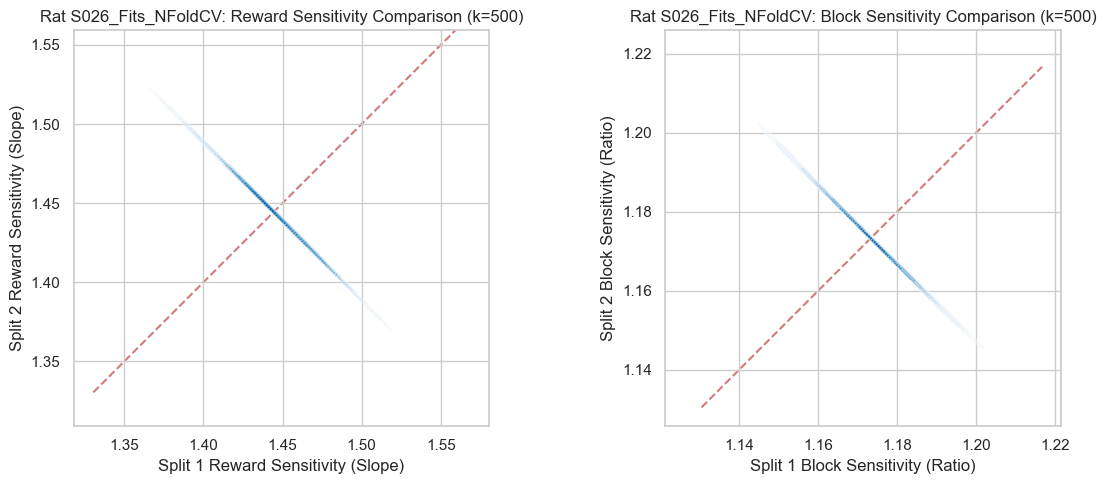

Rat S026_Fits_NFoldCV:
  Std of Reward Sensitivity (Split1 - Split2) = 0.057882
  Std of Block Sensitivity Ratio (Split1 - Split2) = 0.023833


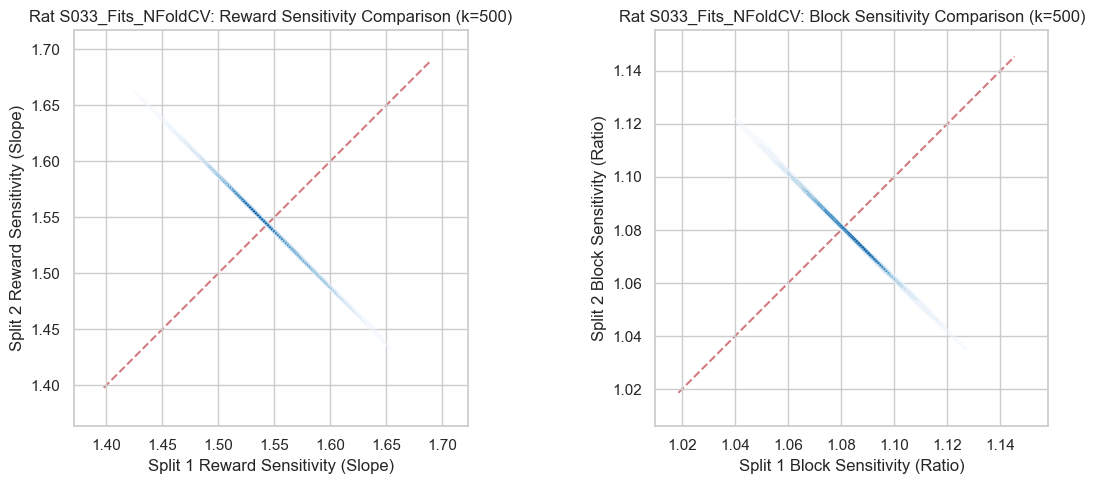

Rat S033_Fits_NFoldCV:
  Std of Reward Sensitivity (Split1 - Split2) = 0.088516
  Std of Block Sensitivity Ratio (Split1 - Split2) = 0.034214


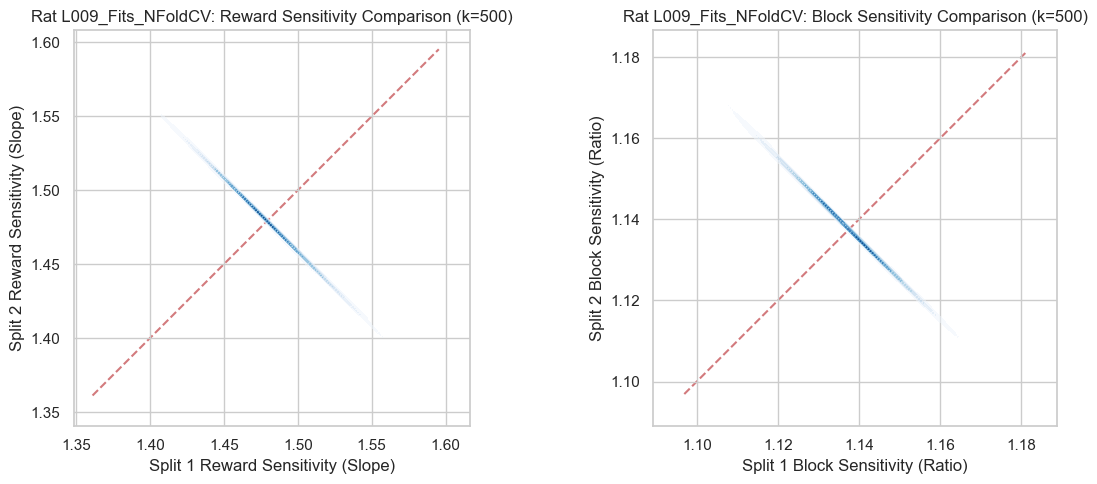

Rat L009_Fits_NFoldCV:
  Std of Reward Sensitivity (Split1 - Split2) = 0.056801
  Std of Block Sensitivity Ratio (Split1 - Split2) = 0.021853


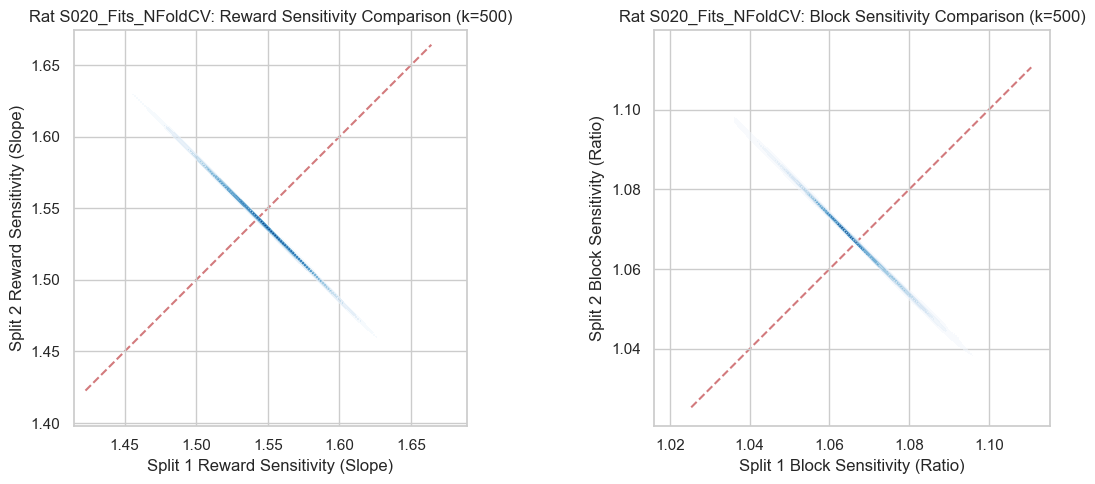

Rat S020_Fits_NFoldCV:
  Std of Reward Sensitivity (Split1 - Split2) = 0.065974
  Std of Block Sensitivity Ratio (Split1 - Split2) = 0.023569


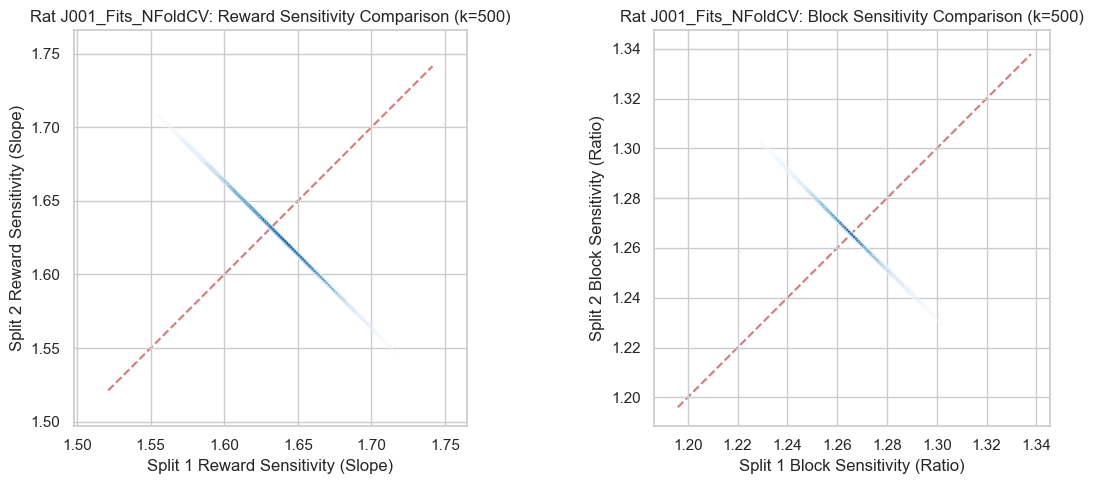

Rat J001_Fits_NFoldCV:
  Std of Reward Sensitivity (Split1 - Split2) = 0.064356
  Std of Block Sensitivity Ratio (Split1 - Split2) = 0.028312


In [25]:
# sort rats by amount of data (number of trials) and select top 5
# filter out rats with insufficient data for analysis
valid_rats = {}
for rat_id, df in all_rat_data.items():
    # filter for optout trials without violations
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)]
    
    # check if rat has enough filtered data and required columns
    if len(filtered_df) > 100:  # need enough data for splits
        try:
            _, test_block_sens_ratio, test_slope = calc_block_sensitivity_and_mixed_slope(filtered_df)
            if not np.isnan(test_block_sens_ratio) and not np.isnan(test_slope):
                # check if all blocks are present
                if len(filtered_df['block'].unique()) == 3:
                    valid_rats[rat_id] = len(filtered_df)
        except:
            continue

# sort valid rats by filtered data amount
sorted_rats = sorted(valid_rats.items(), key=lambda x: x[1], reverse=True)
rat_ids = [rat_id for rat_id, count in sorted_rats[:5]]

print("Selected rats:")
for rat_id in rat_ids:
    print(f"  {rat_id}: {valid_rats[rat_id]} filtered trials")

# analyze each rat
results = {}
for rat_id in rat_ids:
    # get data for this rat
    rat_df = all_rat_data[rat_id]
    
    # perform analysis
    rew_s1, rew_s2, block_s1, block_s2 = analyze_random_splits(rat_df, k=500, rat_id=rat_id)
    
    results[rat_id] = {
        'split1_reward_sensitivity': rew_s1,
        'split2_reward_sensitivity': rew_s2,
        'split1_block_sensitivity': block_s1,
        'split2_block_sensitivity': block_s2,
        'reward_std': np.nanstd(rew_s1 - rew_s2),
        'block_std': np.nanstd(block_s1 - block_s2)
    }

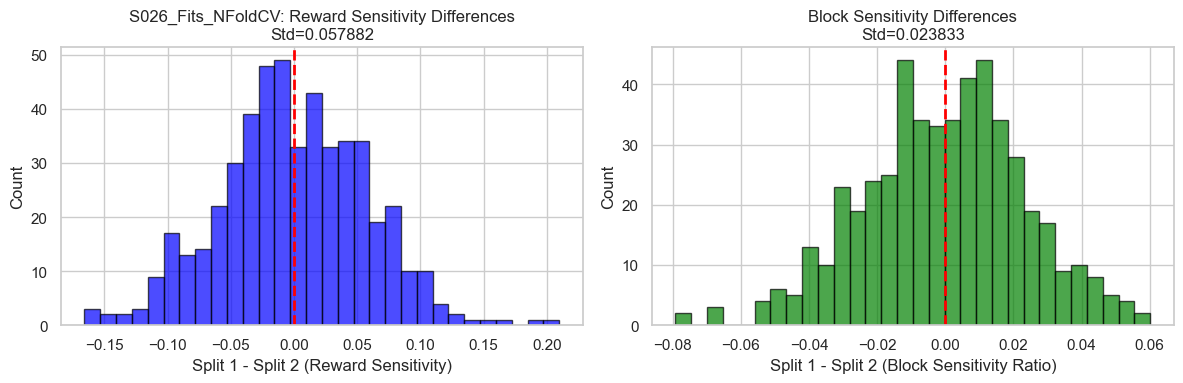

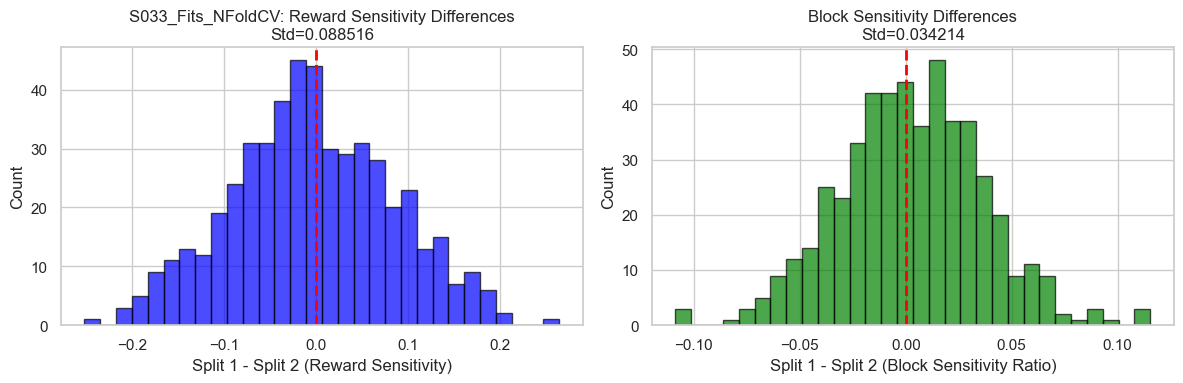

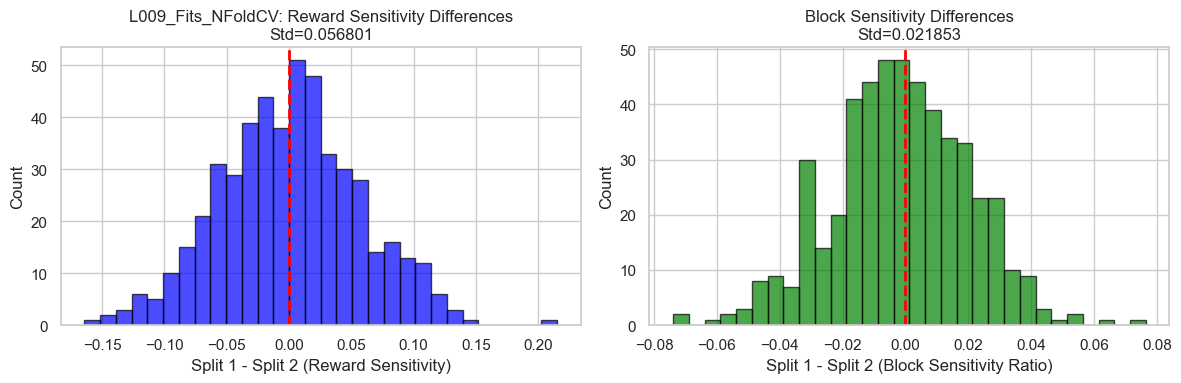

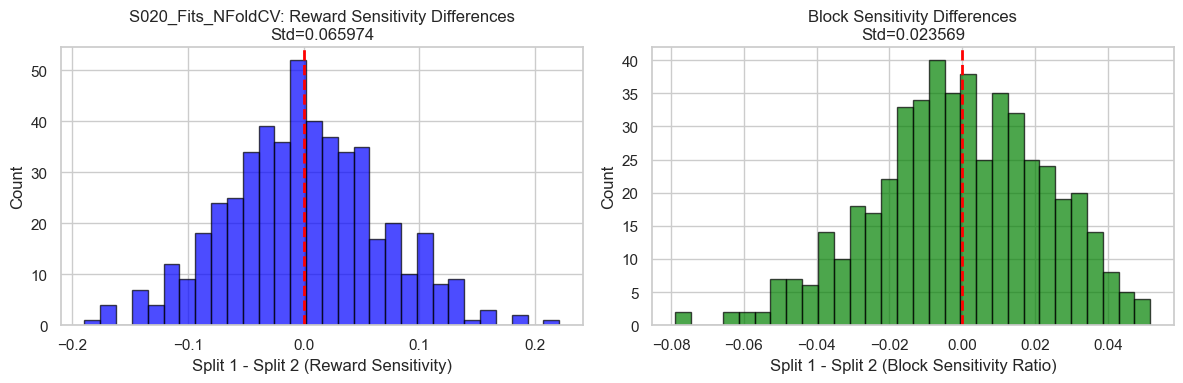

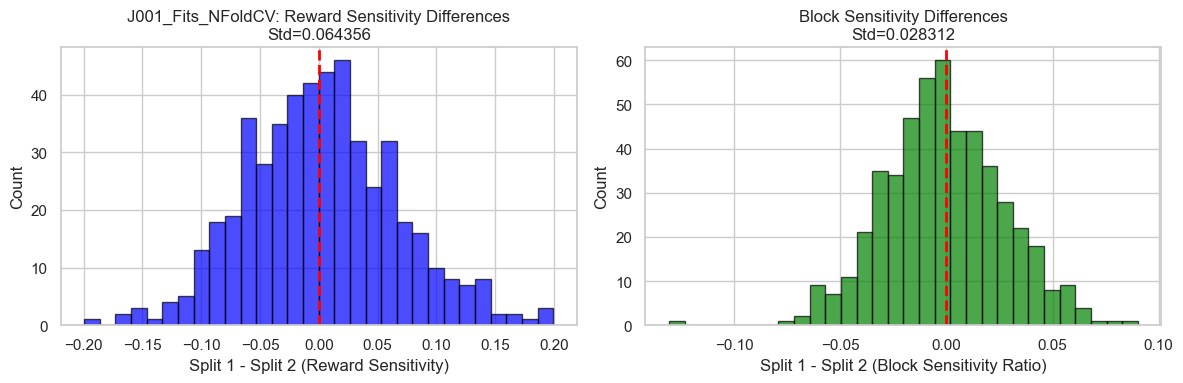

In [7]:
# plot histograms of split differences for each rat
for rat_id in rat_ids[:5]:  # just plot first 5 rats
    if rat_id not in results:
        continue
    
    # get data
    reward_diff = results[rat_id]['split1_reward_sensitivity'] - results[rat_id]['split2_reward_sensitivity']
    block_diff = results[rat_id]['split1_block_sensitivity'] - results[rat_id]['split2_block_sensitivity']
    
    # remove NaN values
    reward_diff = reward_diff[~np.isnan(reward_diff)]
    block_diff = block_diff[~np.isnan(block_diff)]
    
    # create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # reward sensitivity histogram
    ax1.hist(reward_diff, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Split 1 - Split 2 (Reward Sensitivity)')
    ax1.set_ylabel('Count')
    ax1.set_title(f'{rat_id}: Reward Sensitivity Differences\nStd={np.nanstd(reward_diff):.6f}')
    
    # Block sensitivity histogram
    ax2.hist(block_diff, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Split 1 - Split 2 (Block Sensitivity Ratio)')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Block Sensitivity Differences\nStd={np.nanstd(block_diff):.6f}')
    
    plt.tight_layout()
    plt.show()

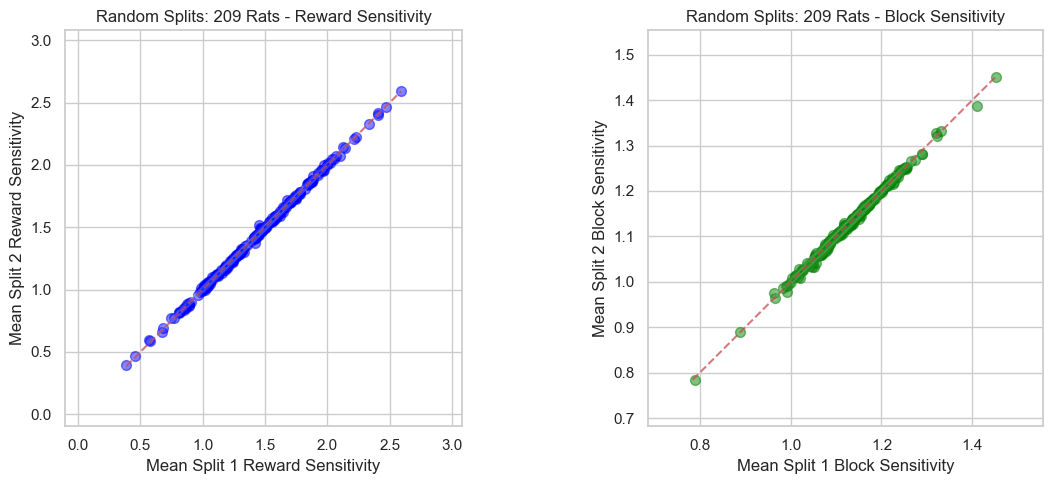

In [8]:
all_rats_reward_s1_mean = []
all_rats_reward_s2_mean = []
all_rats_block_s1_mean = []
all_rats_block_s2_mean = []

# process each rat
for rat_id, df in all_rat_data.items():
    # filter data
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)

    if len(filtered_df) > 100 and len(filtered_df['block'].unique()) == 3:
        split1_reward_sens = []
        split2_reward_sens = []
        split1_block_sens = []
        split2_block_sens = []

        # do 100 splits
        for i in range(100):
            try:
                split1_idx, split2_idx = train_test_split(
                    np.arange(len(filtered_df)),
                    test_size=0.5,
                    stratify=filtered_df['block'],
                    random_state=42 + i
                )

                split1_data = filtered_df.iloc[split1_idx]
                split2_data = filtered_df.iloc[split2_idx]

                if len(split1_data['block'].unique()) < 3 or len(split2_data['block'].unique()) < 3:
                    continue

                _, block_sens1_ratio, slope1 = calc_block_sensitivity_and_mixed_slope(split1_data)
                _, block_sens2_ratio, slope2 = calc_block_sensitivity_and_mixed_slope(split2_data)

                if not (np.isnan(block_sens1_ratio) or np.isnan(slope1) or np.isnan(block_sens2_ratio) or np.isnan(
                        slope2)):
                    split1_reward_sens.append(slope1)
                    split2_reward_sens.append(slope2)
                    split1_block_sens.append(block_sens1_ratio)
                    split2_block_sens.append(block_sens2_ratio)
            except:
                continue

        # calculate means for this rat
        if len(split1_reward_sens) > 0:
            all_rats_reward_s1_mean.append(np.mean(split1_reward_sens))
            all_rats_reward_s2_mean.append(np.mean(split2_reward_sens))
            all_rats_block_s1_mean.append(np.mean(split1_block_sens))
            all_rats_block_s2_mean.append(np.mean(split2_block_sens))

# create figure with 2 plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Reward sensitivity
ax1.scatter(all_rats_reward_s1_mean, all_rats_reward_s2_mean, alpha=0.5, s=50, color='blue')
lims = [min(all_rats_reward_s1_mean + all_rats_reward_s2_mean),
        max(all_rats_reward_s1_mean + all_rats_reward_s2_mean)]
ax1.plot(lims, lims, 'r--', alpha=0.75)
sns.kdeplot(x=all_rats_reward_s1_mean, y=all_rats_reward_s2_mean,
            fill=True, cmap='Blues', alpha=0.1, ax=ax1)
ax1.set_xlabel('Mean Split 1 Reward Sensitivity')
ax1.set_ylabel('Mean Split 2 Reward Sensitivity')
ax1.set_title(f'Random Splits: {len(all_rats_reward_s1_mean)} Rats - Reward Sensitivity')
ax1.set_aspect('equal')

# Plot 2: Block sensitivity
ax2.scatter(all_rats_block_s1_mean, all_rats_block_s2_mean, alpha=0.5, s=50, color='green')
lims = [min(all_rats_block_s1_mean + all_rats_block_s2_mean),
        max(all_rats_block_s1_mean + all_rats_block_s2_mean)]
ax2.plot(lims, lims, 'r--', alpha=0.75)
sns.kdeplot(x=all_rats_block_s1_mean, y=all_rats_block_s2_mean,
            fill=True, cmap='Greens', alpha=0.1, ax=ax2)
ax2.set_xlabel('Mean Split 1 Block Sensitivity')
ax2.set_ylabel('Mean Split 2 Block Sensitivity')
ax2.set_title(f'Random Splits: {len(all_rats_block_s1_mean)} Rats - Block Sensitivity')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

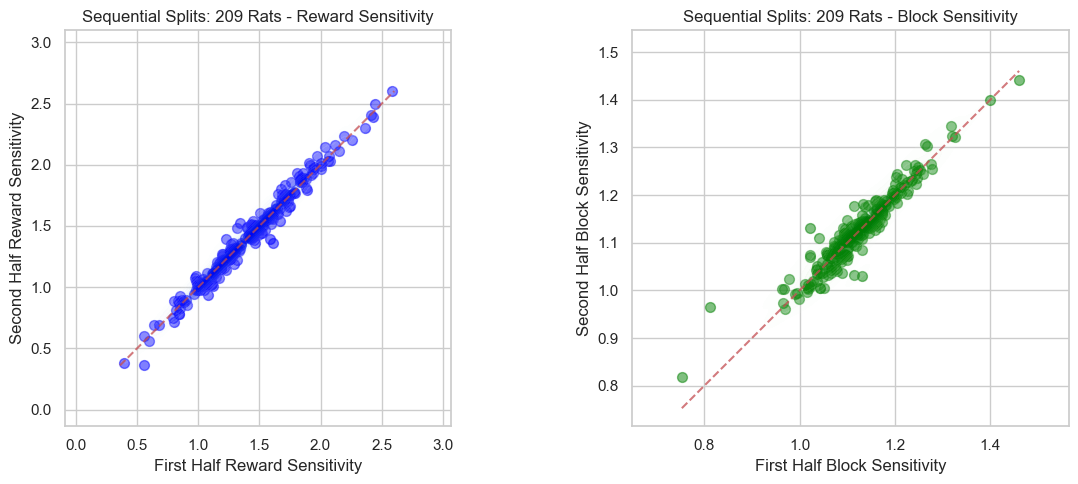

In [9]:
all_rats_reward_s1_mean_seq = []
all_rats_reward_s2_mean_seq = []
all_rats_block_s1_mean_seq = []
all_rats_block_s2_mean_seq = []

# process each rat
for rat_id, df in all_rat_data.items():
    # filter data
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)

    if len(filtered_df) > 100 and len(filtered_df['block'].unique()) == 3:
        split1_reward_sens = []
        split2_reward_sens = []
        split1_block_sens = []
        split2_block_sens = []

        n = len(filtered_df)
        half = n // 2

        # sequential split
        split1_data = filtered_df.iloc[:half]
        split2_data = filtered_df.iloc[half:]

        # check if both halves have all blocks
        if len(split1_data['block'].unique()) == 3 and len(split2_data['block'].unique()) == 3:
            try:
                _, block_sens1_ratio, slope1 = calc_block_sensitivity_and_mixed_slope(split1_data)
                _, block_sens2_ratio, slope2 = calc_block_sensitivity_and_mixed_slope(split2_data)

                if not (np.isnan(block_sens1_ratio) or np.isnan(slope1) or np.isnan(block_sens2_ratio) or np.isnan(
                        slope2)):
                    all_rats_reward_s1_mean_seq.append(slope1)
                    all_rats_reward_s2_mean_seq.append(slope2)
                    all_rats_block_s1_mean_seq.append(block_sens1_ratio)
                    all_rats_block_s2_mean_seq.append(block_sens2_ratio)
            except:
                continue

# create figure with 2 plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Reward sensitivity
ax1.scatter(all_rats_reward_s1_mean_seq, all_rats_reward_s2_mean_seq, alpha=0.5, s=50, color='blue')
lims = [min(all_rats_reward_s1_mean_seq + all_rats_reward_s2_mean_seq),
        max(all_rats_reward_s1_mean_seq + all_rats_reward_s2_mean_seq)]
ax1.plot(lims, lims, 'r--', alpha=0.75)
sns.kdeplot(x=all_rats_reward_s1_mean_seq, y=all_rats_reward_s2_mean_seq,
            fill=True, cmap='Blues', alpha=0.1, ax=ax1)
ax1.set_xlabel('First Half Reward Sensitivity')
ax1.set_ylabel('Second Half Reward Sensitivity')
ax1.set_title(f'Sequential Splits: {len(all_rats_reward_s1_mean_seq)} Rats - Reward Sensitivity')
ax1.set_aspect('equal')

# Plot 2: Block sensitivity
ax2.scatter(all_rats_block_s1_mean_seq, all_rats_block_s2_mean_seq, alpha=0.5, s=50, color='green')
lims = [min(all_rats_block_s1_mean_seq + all_rats_block_s2_mean_seq),
        max(all_rats_block_s1_mean_seq + all_rats_block_s2_mean_seq)]
ax2.plot(lims, lims, 'r--', alpha=0.75)
sns.kdeplot(x=all_rats_block_s1_mean_seq, y=all_rats_block_s2_mean_seq,
            fill=True, cmap='Greens', alpha=0.1, ax=ax2)
ax2.set_xlabel('First Half Block Sensitivity')
ax2.set_ylabel('Second Half Block Sensitivity')
ax2.set_title(f'Sequential Splits: {len(all_rats_block_s1_mean_seq)} Rats - Block Sensitivity')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

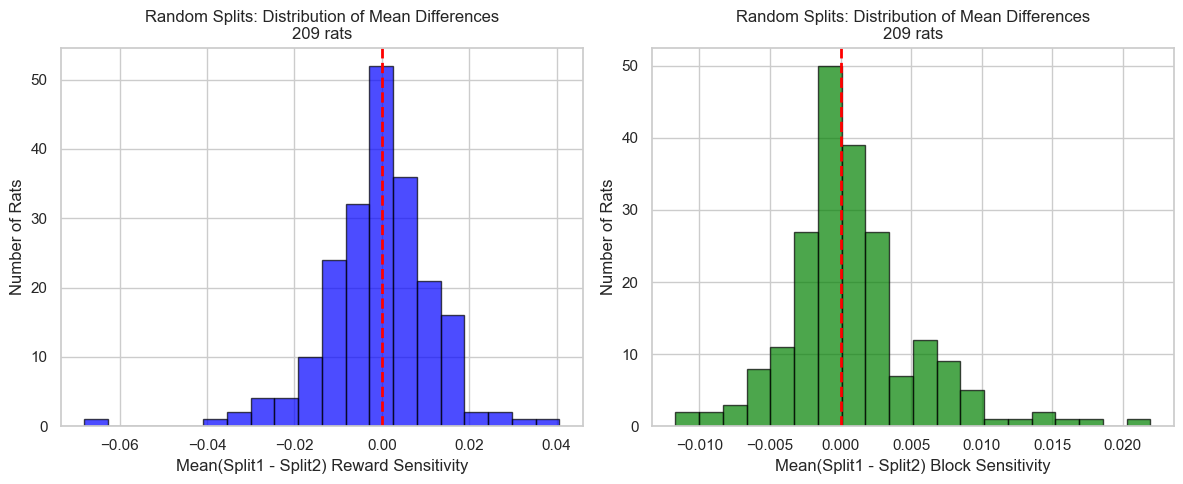

In [10]:
rat_reward_mean_diffs = []
rat_block_mean_diffs = []

for rat_id, df in all_rat_data.items():
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)

    if len(filtered_df) > 100 and len(filtered_df['block'].unique()) == 3:
        reward_diffs = []
        block_diffs = []

        # Do 100 splits
        for i in range(100):
            try:
                split1_idx, split2_idx = train_test_split(
                    np.arange(len(filtered_df)),
                    test_size=0.5,
                    stratify=filtered_df['block'],
                    random_state=42 + i
                )

                split1_data = filtered_df.iloc[split1_idx]
                split2_data = filtered_df.iloc[split2_idx]

                if len(split1_data['block'].unique()) < 3 or len(split2_data['block'].unique()) < 3:
                    continue

                _, block_sens1_ratio, slope1 = calc_block_sensitivity_and_mixed_slope(split1_data)
                _, block_sens2_ratio, slope2 = calc_block_sensitivity_and_mixed_slope(split2_data)

                if not (np.isnan(block_sens1_ratio) or np.isnan(slope1) or np.isnan(block_sens2_ratio) or np.isnan(
                        slope2)):
                    reward_diffs.append(slope1 - slope2)
                    block_diffs.append(block_sens1_ratio - block_sens2_ratio)
            except:
                continue

        # calculate mean(s1-s2) for this rat
        if len(reward_diffs) > 0:
            rat_reward_mean_diffs.append(np.mean(reward_diffs))
            rat_block_mean_diffs.append(np.mean(block_diffs))

# create histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# reward sensitivity histogram
ax1.hist(rat_reward_mean_diffs, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Mean(Split1 - Split2) Reward Sensitivity')
ax1.set_ylabel('Number of Rats')
ax1.set_title(f'Random Splits: Distribution of Mean Differences\n{len(rat_reward_mean_diffs)} rats')

# block sensitivity histogram
ax2.hist(rat_block_mean_diffs, bins=20, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Mean(Split1 - Split2) Block Sensitivity')
ax2.set_ylabel('Number of Rats')
ax2.set_title(f'Random Splits: Distribution of Mean Differences\n{len(rat_block_mean_diffs)} rats')

plt.tight_layout()
plt.show()

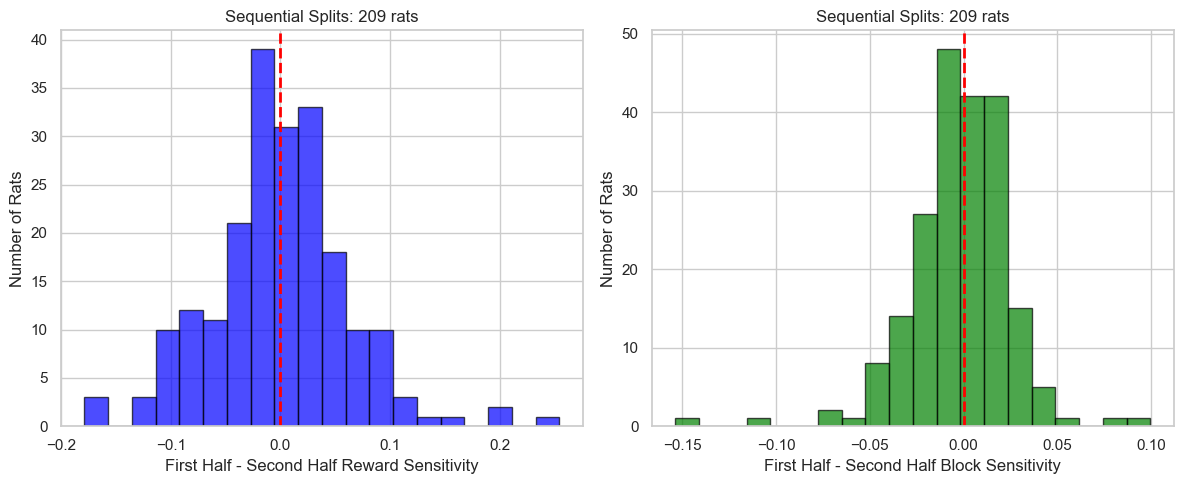

In [11]:
seq_reward_diffs = [s1 - s2 for s1, s2 in zip(all_rats_reward_s1_mean_seq, all_rats_reward_s2_mean_seq)]
seq_block_diffs = [s1 - s2 for s1, s2 in zip(all_rats_block_s1_mean_seq, all_rats_block_s2_mean_seq)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(seq_reward_diffs, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('First Half - Second Half Reward Sensitivity')
ax1.set_ylabel('Number of Rats')
ax1.set_title(f'Sequential Splits: {len(seq_reward_diffs)} rats')

ax2.hist(seq_block_diffs, bins=20, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('First Half - Second Half Block Sensitivity')
ax2.set_ylabel('Number of Rats')
ax2.set_title(f'Sequential Splits: {len(seq_block_diffs)} rats')

plt.tight_layout()
plt.show()

In [12]:
np.random.seed(42)

# get all valid rats
valid_rat_ids = []
for rat_id, df in all_rat_data.items():
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)]
    if len(filtered_df) > 100 and len(filtered_df['block'].unique()) == 3:
        # check if rat has 20 µL reward data
        if 20 in filtered_df['reward'].unique():
            valid_rat_ids.append(rat_id)

# randomly select 10 rats
selected_10_rats = np.random.choice(valid_rat_ids, size=min(10, len(valid_rat_ids)), replace=False)
print(f"Selected {len(selected_10_rats)} rats: {selected_10_rats}")

Selected 10 rats: ['S030_Fits_NFoldCV' 'S046_Fits_NFoldCV' 'J067_Fits_NFoldCV'
 'L003_Fits_NFoldCV' 'J020_Fits_NFoldCV' 'L018_Fits_NFoldCV'
 'S021_Fits_NFoldCV' 'J069_Fits_NFoldCV' 'L031_Fits_NFoldCV'
 'J076_Fits_NFoldCV']


In [13]:
rat_results = {}
k = 500

for rat_id in selected_10_rats:
    df = all_rat_data[rat_id]
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)

    # calculate whole data values
    _, block_sens_whole, slope_whole = calc_block_sensitivity_and_mixed_slope(filtered_df)

    # calculate split values (2k = 1000 splits)
    reward_split_values = []
    block_split_values = []

    for i in range(2 * k):  # 2k = 1000 splits
        split1_idx, split2_idx = train_test_split(
            np.arange(len(filtered_df)),
            test_size=0.5,
            stratify=filtered_df['block'],
            random_state=42 + i
        )

        split_data = filtered_df.iloc[split1_idx]  # using one random half

        if len(split_data['block'].unique()) == 3:
            _, block_sens_split, slope_split = calc_block_sensitivity_and_mixed_slope(split_data)

            if not (np.isnan(block_sens_split) or np.isnan(slope_split)):
                reward_split_values.append(slope_split)
                block_split_values.append(block_sens_split)

    # store results
    rat_results[rat_id] = {
        'reward_whole': slope_whole,
        'block_whole': block_sens_whole,
        'reward_split_mean': np.mean(reward_split_values),
        'reward_split_std': np.std(reward_split_values),
        'block_split_mean': np.mean(block_split_values),
        'block_split_std': np.std(block_split_values),
        'reward_split_values': reward_split_values,
        'block_split_values': block_split_values
    }

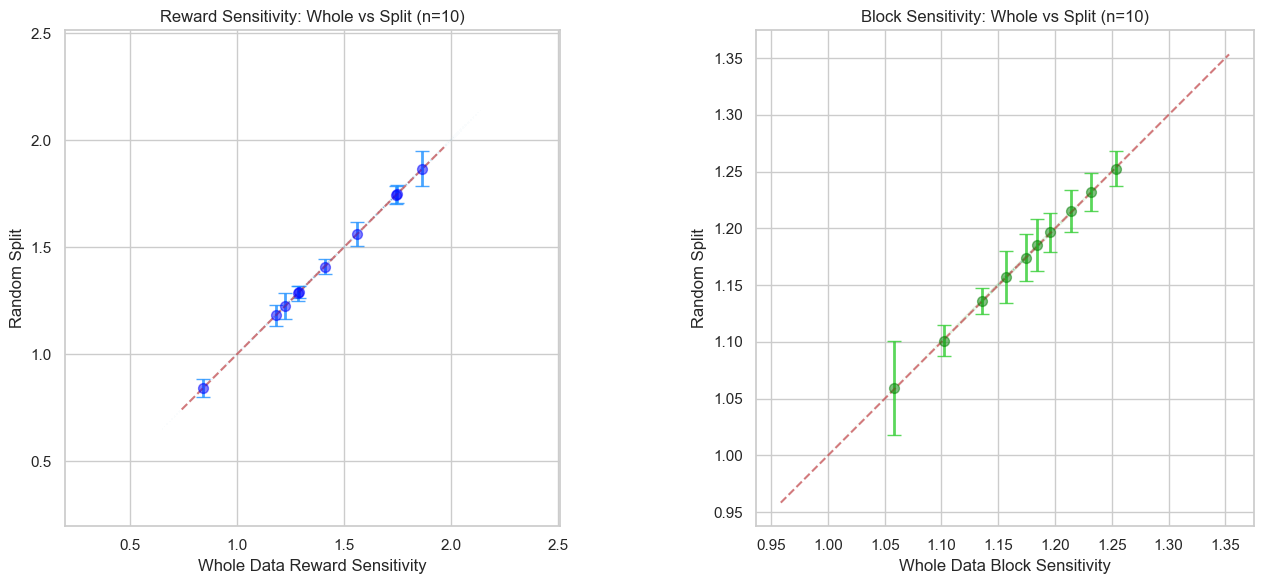

In [14]:
# prepare data for plotting
whole_reward = [rat_results[rat]['reward_whole'] for rat in selected_10_rats]
whole_block = [rat_results[rat]['block_whole'] for rat in selected_10_rats]
split_reward_mean = [rat_results[rat]['reward_split_mean'] for rat in selected_10_rats]
split_block_mean = [rat_results[rat]['block_split_mean'] for rat in selected_10_rats]
split_reward_std = [rat_results[rat]['reward_split_std'] for rat in selected_10_rats]
split_block_std = [rat_results[rat]['block_split_std'] for rat in selected_10_rats]

# create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot 1: reward sensitivity
# error bars
ax1.errorbar(whole_reward, split_reward_mean, yerr=split_reward_std,
             fmt='none', ecolor='dodgerblue', alpha=0.8, capsize=5, linewidth=2)

# scatter points
ax1.scatter(whole_reward, split_reward_mean, alpha=0.5, s=50, color='blue', zorder=5)

# 2d density
sns.kdeplot(x=whole_reward, y=split_reward_mean,
            fill=True, cmap='Blues', alpha=0.1, ax=ax1)

# x=y line
lims = [min(whole_reward + split_reward_mean) - 0.1,
        max(whole_reward + split_reward_mean) + 0.1]
ax1.plot(lims, lims, 'r--', alpha=0.75)

ax1.set_xlabel('Whole Data Reward Sensitivity')
ax1.set_ylabel('Random Split')
ax1.set_title(f'Reward Sensitivity: Whole vs Split (n={len(selected_10_rats)})')
ax1.set_aspect('equal')

# plot 2: block sensitivity
# error bars
ax2.errorbar(whole_block, split_block_mean, yerr=split_block_std,
             fmt='none', ecolor='limegreen', alpha=0.8, capsize=5, linewidth=2)

# scatter points
ax2.scatter(whole_block, split_block_mean, alpha=0.5, s=50, color='green', zorder=5)

# 2d density
sns.kdeplot(x=whole_block, y=split_block_mean,
            fill=True, cmap='Greens', alpha=0.1, ax=ax2)

# x=y line
lims = [min(whole_block + split_block_mean) - 0.1,
        max(whole_block + split_block_mean) + 0.1]
ax2.plot(lims, lims, 'r--', alpha=0.75)

ax2.set_xlabel('Whole Data Block Sensitivity')
ax2.set_ylabel('Random Split')
ax2.set_title(f'Block Sensitivity: Whole vs Split (n={len(selected_10_rats)})')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

In [15]:
valid_rat_ids = []
for rat_id, df in all_rat_data.items():
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)]
    if len(filtered_df) > 100 and len(filtered_df['block'].unique()) == 3:
        # check if rat has 20 µL reward data
        if 20 in filtered_df['reward'].unique():
            valid_rat_ids.append(rat_id)

In [16]:
rat_results_all = {}
k = 100

for idx, rat_id in enumerate(valid_rat_ids):
    df = all_rat_data[rat_id]
    filtered_df = df[(df['optout'] == 1) & (df['vios'] == 0)].copy()
    filtered_df = filtered_df.reset_index(drop=True)

    # calculate whole data values
    _, block_sens_whole, slope_whole = calc_block_sensitivity_and_mixed_slope(filtered_df)

    # calculate split values (2k = 200 splits)
    reward_split_values = []
    block_split_values = []

    for i in range(2 * k):  # 2k = 200 splits
        split1_idx, split2_idx = train_test_split(
            np.arange(len(filtered_df)),
            test_size=0.5,
            stratify=filtered_df['block'],
            random_state=42 + i
        )

        split_data = filtered_df.iloc[split1_idx]  # using one random half

        if len(split_data['block'].unique()) == 3:
            _, block_sens_split, slope_split = calc_block_sensitivity_and_mixed_slope(split_data)

            if not (np.isnan(block_sens_split) or np.isnan(slope_split)):
                reward_split_values.append(slope_split)
                block_split_values.append(block_sens_split)

    # store results
    rat_results_all[rat_id] = {
        'reward_whole': slope_whole,
        'block_whole': block_sens_whole,
        'reward_split_mean': np.mean(reward_split_values),
        'reward_split_std': np.std(reward_split_values),
        'block_split_mean': np.mean(block_split_values),
        'block_split_std': np.std(block_split_values),
        'reward_split_values': reward_split_values,
        'block_split_values': block_split_values
    }

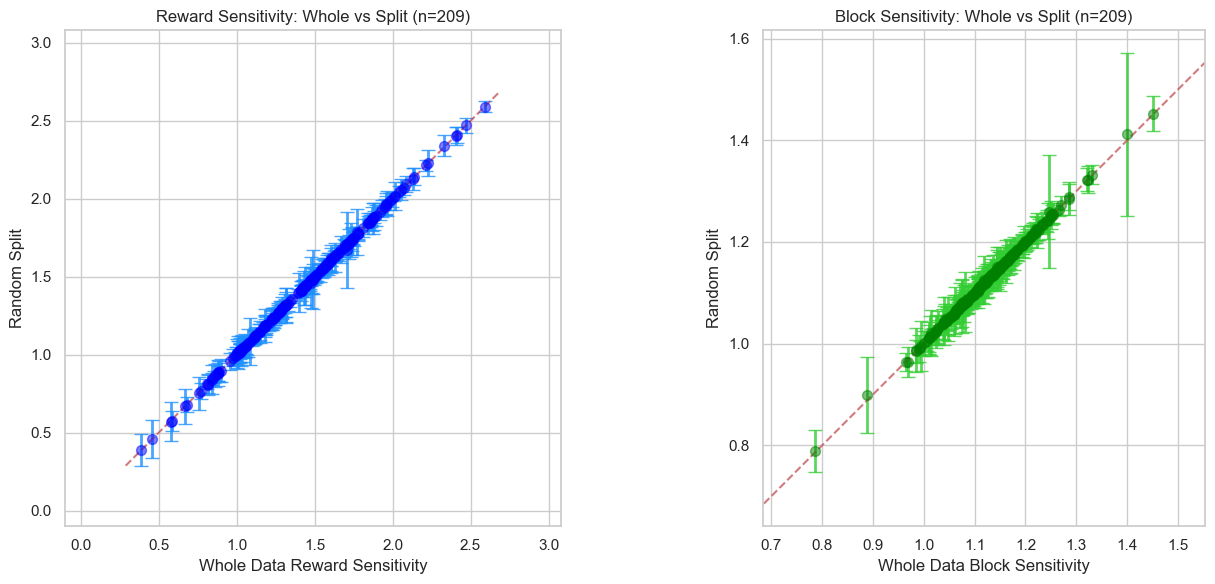

In [17]:
whole_reward_all = [rat_results_all[rat]['reward_whole'] for rat in valid_rat_ids]
whole_block_all = [rat_results_all[rat]['block_whole'] for rat in valid_rat_ids]
split_reward_mean_all = [rat_results_all[rat]['reward_split_mean'] for rat in valid_rat_ids]
split_block_mean_all = [rat_results_all[rat]['block_split_mean'] for rat in valid_rat_ids]
split_reward_std_all = [rat_results_all[rat]['reward_split_std'] for rat in valid_rat_ids]
split_block_std_all = [rat_results_all[rat]['block_split_std'] for rat in valid_rat_ids]

# create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot 1: reward sensitivity
# error bars
ax1.errorbar(whole_reward_all, split_reward_mean_all, yerr=split_reward_std_all,
             fmt='none', ecolor='dodgerblue', alpha=0.8, capsize=5, linewidth=2)

# scatter points
ax1.scatter(whole_reward_all, split_reward_mean_all, alpha=0.5, s=50, color='blue', zorder=5)

# 2d density
sns.kdeplot(x=whole_reward_all, y=split_reward_mean_all,
            fill=True, cmap='Blues', alpha=0.1, ax=ax1)

# x=y line
lims = [min(whole_reward_all + split_reward_mean_all) - 0.1,
        max(whole_reward_all + split_reward_mean_all) + 0.1]
ax1.plot(lims, lims, 'r--', alpha=0.75)

ax1.set_xlabel('Whole Data Reward Sensitivity')
ax1.set_ylabel('Random Split')
ax1.set_title(f'Reward Sensitivity: Whole vs Split (n={len(valid_rat_ids)})')
ax1.set_aspect('equal')

# plot 2: block sensitivity
# error bars
ax2.errorbar(whole_block_all, split_block_mean_all, yerr=split_block_std_all,
             fmt='none', ecolor='limegreen', alpha=0.8, capsize=5, linewidth=2)

# scatter points
ax2.scatter(whole_block_all, split_block_mean_all, alpha=0.5, s=50, color='green', zorder=5)

# 2d density
sns.kdeplot(x=whole_block_all, y=split_block_mean_all,
            fill=True, cmap='Greens', alpha=0.1, ax=ax2)

# x=y line
lims = [min(whole_block_all + split_block_mean_all) - 0.1,
        max(whole_block_all + split_block_mean_all) + 0.1]
ax2.plot(lims, lims, 'r--', alpha=0.75)

ax2.set_xlabel('Whole Data Block Sensitivity')
ax2.set_ylabel('Random Split')
ax2.set_title(f'Block Sensitivity: Whole vs Split (n={len(valid_rat_ids)})')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()